In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi

Wed Oct  3 12:47:47 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0  On |                  N/A |
| 32%   56C    P8    18W / 250W |   1185MiB / 11169MiB |      5%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 52%   83C    P2   122W / 250W |  10786MiB / 11172MiB |      6%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

## Create DATASET

### 1 - Split train test

In [5]:
import json 

In [6]:
data_path = '/root/data/aquabyte-images/'
coco_file_dir = 'cocofiles'
targets = ['full']

In [7]:
target_coco_files = []
for file in os.listdir(data_path + coco_file_dir):
    count = 0
    for target in targets:
        if target in file:
            count += 1
    if count == len(targets):
        target_coco_files.append(file)  
size_dict = {}
datas = []
for coco_file in target_coco_files:
    with open(data_path + coco_file_dir + '/' + coco_file) as f:
        coco_dict = json.load(f)
        datas.append(coco_dict)
        size = len(coco_dict['annotations'])
        size_dict[size] = data_path + coco_file_dir + '/' + coco_file

In [8]:
test_coco_sizes = [x for x in size_dict.keys() if x < 800]
print('Split is {}'.format(float(sum(test_coco_sizes)) / sum(size_dict.keys())))
test_coco_files = [size_dict[x] for x in test_coco_sizes]
train_coco_files = [size_dict[x] for x in list(set(size_dict.keys()) - set(test_coco_sizes))]

Split is 0.21216761278757096


### 2 - Datasets

In [9]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import keras

sys.path.insert(0, '../libraries')
from mrcnn.config import Config
import mrcnn.utils as utils
import mrcnn.model as modellib
import mrcnn.visualize as visualize
from mrcnn.model import log
import mcoco.coco as coco
# import mextra.utils as extra_utils
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline
%config IPCompleter.greedy=True
BASE_DIR = '/root/data/models/erko/mask_rcnn_instance_segmentation'
DATA_DIR = '/root/data/erko/'
WEIGHTS_DIR = os.path.join(BASE_DIR, "weights")
MODEL_DIR = os.path.join(BASE_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(WEIGHTS_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [10]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [11]:
dataset_train = coco.CocoDataset()
for coco_file in train_coco_files:
    dataset_train.load_coco(coco_file, class_ids=[0])
dataset_train.prepare()
print("Number of train images: {}".format(dataset_train.num_images))

loading annotations into memory...
Done (t=0.49s)
creating index...
index created!
loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
loading annotations into memory...
Done (t=0.32s)
creating index...
index created!
loading annotations into memory...
Done (t=0.99s)
creating index...
index created!
loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
Number of train images: 10592


In [12]:
dataset_validate = coco.CocoDataset()
for coco_file in test_coco_files:
    dataset_validate.load_coco(coco_file, class_ids=[0])
dataset_validate.prepare()
print("Number of train images: {}".format(dataset_validate.num_images))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
load

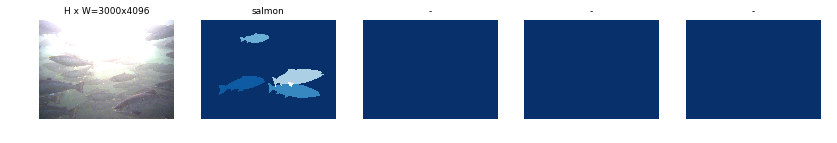

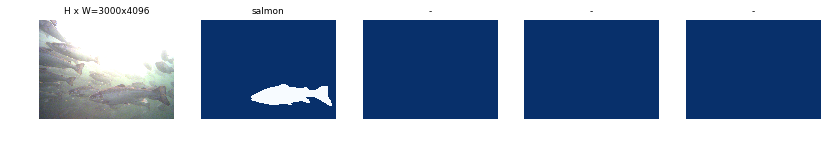

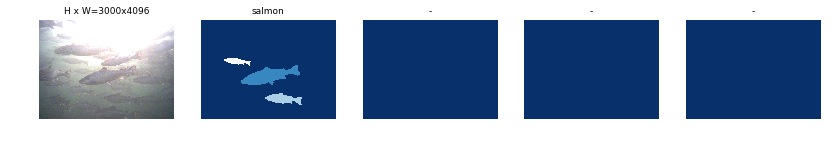

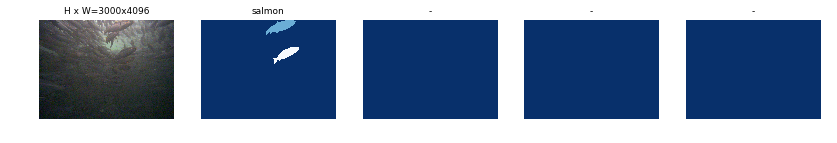

In [13]:
# Load and display random samples# Load  
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Configuration

In [14]:
image_size = 512
rpn_anchor_template = (1, 2, 4, 8, 16) # anchor sizes in pixels
rpn_anchor_scales = tuple(i * (image_size // 16) for i in rpn_anchor_template)

class FishConfig(Config):
    """Configuration for training on the shapes dataset.
    """
    # name your experiments here
    NAME = "full"

    # Train on 1 GPU and 2 images per GPU. Put multiple images on each
    # GPU if the images are small. Batch size is 2 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes (triangles, circles, and squares)

    # Use smaller images for faster training. 
    IMAGE_MAX_DIM = image_size
    IMAGE_MIN_DIM = image_size
    
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = rpn_anchor_scales

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    STEPS_PER_EPOCH = 1000

    VALIDATION_STEPS = 300
    
config = FishConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_bbox_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MI

## Model

In [15]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

In [9]:
inititalize_weights_with = "coco"  # imagenet, coco, or last

if inititalize_weights_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
    
elif inititalize_weights_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
    
elif inititalize_weights_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

In [10]:
# add more callbacks here if necessary
callbacks = [
    keras.callbacks.TensorBoard(log_dir=model.log_dir,
                                histogram_freq=0, write_graph=True, write_images=False),
    keras.callbacks.ModelCheckpoint(model.checkpoint_path,
                                    verbose=0, save_weights_only=True),
]

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [ ]:
model.train(dataset_train, dataset_validate, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=100, # starts from the previous epoch, so only 1 additional is trained 
            layers="all",
            callback_list=callbacks)


Starting at epoch 0. LR=0.0001

Checkpoint Path: /root/data/models/erko/mask_rcnn_instance_segmentation/logs/full_20181002_19H09/mask_rcnn_full_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_bran

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training_generator.py:46: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100
1000/1000 [==============================] - 569s 569ms/step - loss: 0.9618 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1577 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.2879 - mrcnn_mask_loss: 0.2324 - val_loss: 0.5667 - val_rpn_class_loss: 0.0102 - val_rpn_bbox_loss: 0.0929 - val_mrcnn_class_loss: 0.1333 - val_mrcnn_bbox_loss: 0.1611 - val_mrcnn_mask_loss: 0.1692
Epoch 2/100
1000/1000 [==============================] - 495s 495ms/step - loss: 0.6293 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1073 - mrcnn_class_loss: 0.1745 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.1905 - val_loss: 0.4724 - val_rpn_class_loss: 0.0074 - val_rpn_bbox_loss: 0.0812 - val_mrcnn_class_loss: 0.1152 - val_mrcnn_bbox_loss: 0.1117 - val_mrcnn_mask_loss: 0.1570
Epoch 3/100
1000/1000 [==============================] - 490s 490ms/step - loss: 0.5777 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0900 - mrcnn_class_loss: 0.1689 - mrcnn_bbox_loss: 0.1233 - mrcnn_mask_loss: 0.1839 - val_loss: 0.4206

## Detection

### 1 - Inference config

In [16]:
model_path = '/root/data/models/erko/mask_rcnn_instance_segmentation/logs/full_20181002_19H09/mask_rcnn_full_0097.h5'

In [17]:
class InferenceConfig(FishConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
model_path = '/root/data/models/erko/mask_rcnn_instance_segmentation/logs/full_20181002_19H09/mask_rcnn_full_0097.h5'
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /root/data/models/erko/mask_rcnn_instance_segmentation/logs/full_20181002_19H09/mask_rcnn_full_0097.h5


### 2 - Visualisation of prediction on every image of test set

**Instructions** : Press enter to continue to next image, and ctrl + c or pause the kernel to stop (then enter)

original_image           shape: (512, 512, 3)         min:    0.00000  max:  139.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 4096.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   34.00000  max:  500.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool


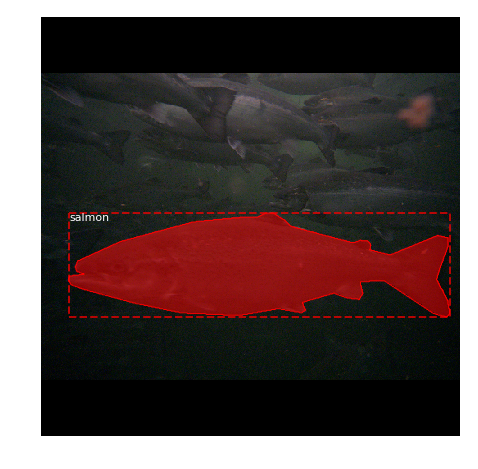

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  139.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   28.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


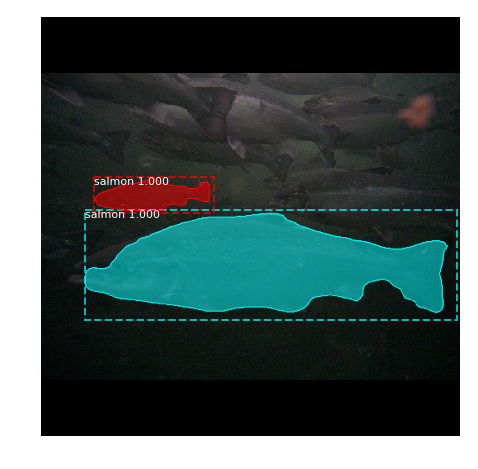

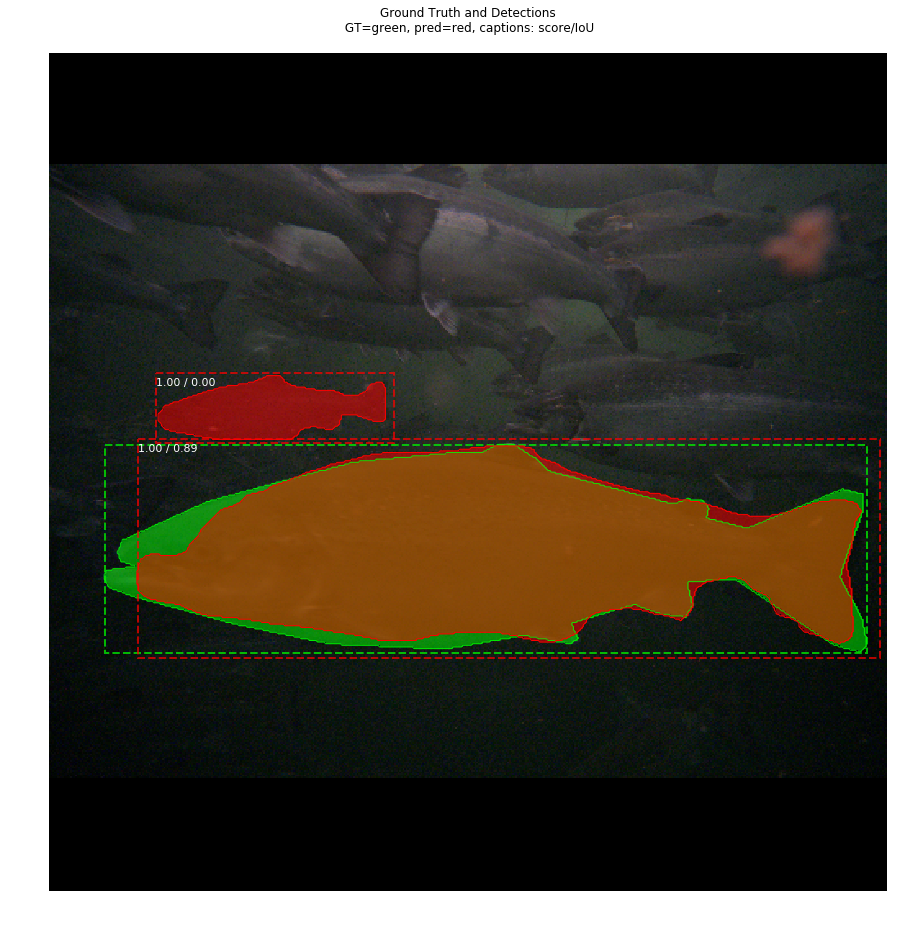

Press enter to continue: 
original_image           shape: (512, 512, 3)         min:    0.00000  max:  155.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 4096.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:   83.00000  max:  372.00000  int32
gt_mask                  shape: (512, 512, 2)         min:    0.00000  max:    1.00000  bool


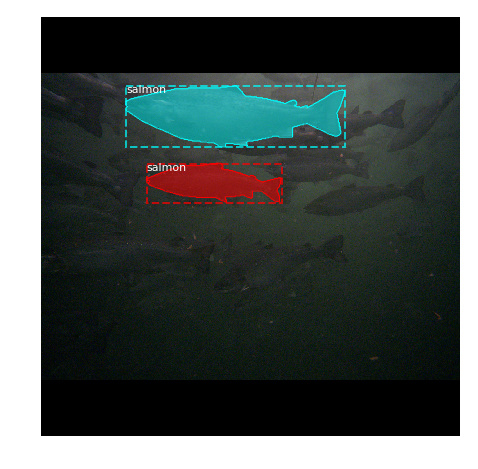

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  155.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   31.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


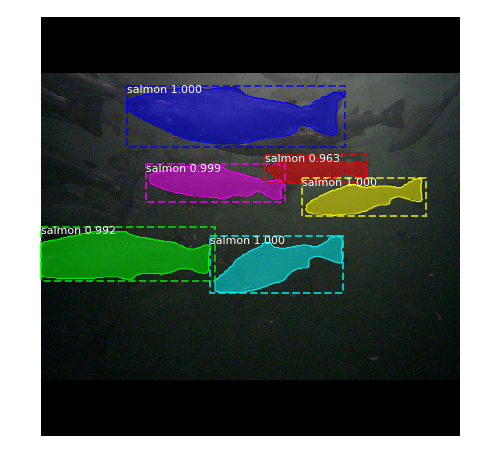

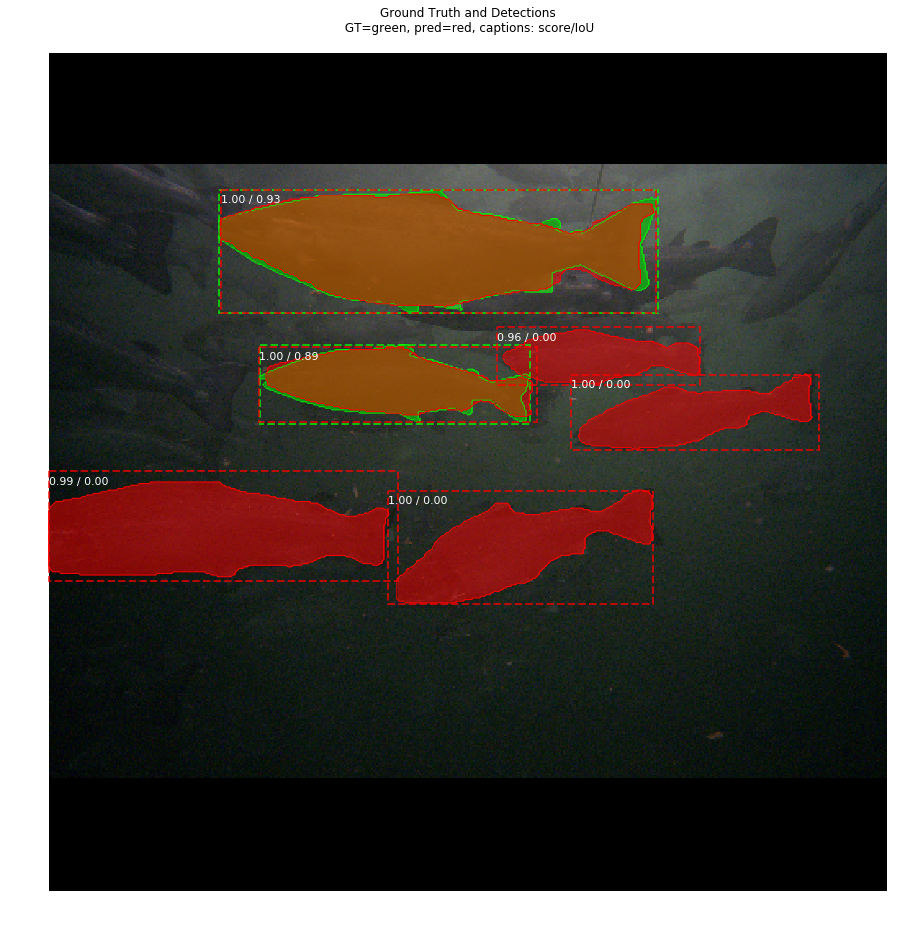

Press enter to continue: q


In [22]:
try:
    while True:
        for image_id in dataset_validate.image_ids:
            original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_validate, inference_config, 
                           image_id, use_mini_mask=False)

            log("original_image", original_image)
            log("image_meta", image_meta)
            log("gt_class_id", gt_class_id)
            log("gt_bbox", gt_bbox)
            log("gt_mask", gt_mask)

            visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_validate.class_names, figsize=(8, 8))

            results = model.detect([original_image], verbose=1)
            r = results[0]
            visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_validate.class_names, r['scores'], ax=get_ax())

            visualize.display_differences(original_image, gt_bbox, gt_class_id, gt_mask,
                        r['rois'], r['class_ids'], r['scores'], r['masks'],
                        dataset_validate.class_names)

            input('Press enter to continue: ')
except KeyboardInterrupt:
    pass

### 3 - Evaluation of prediction on every image of test set

In [57]:
dataset_validate.class_info = [{'id': 0, 'name': 'BG', 'source': ''},
 {'id': 1, 'name': 'salmon', 'source': 'coco'}]

#### 3.1 - mAP

In [58]:
from mextra.utils import compute_per_class_precision, compute_multiple_per_class_precision

In [59]:
predictions =\
compute_multiple_per_class_precision(model, inference_config, dataset_validate, iou_threshold=0.5)
complete_predictions = []

for shape in predictions:
    complete_predictions += predictions[shape]
    print("{} ({}): {}".format(shape, len(predictions[shape]), np.mean(predictions[shape])))

print("--------")
print("average: {}".format(np.mean(complete_predictions)))

salmon (3214): 0.6074190809603922
--------
average: 0.6074190809603922


In [ ]:
print("average: {}".format(np.mean(complete_predictions)))

#### 3.2 - Complementary metrics

Histograms of detected fishes & Mean IOU

In [60]:
from mextra.utils import compute_per_class_precision

In [ ]:
d = {'nb_gt_fish':[], 'nb_pred_fish':[]}
mean_overlaps = []
for image_id in dataset_validate.image_ids:
    image, _, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_validate, inference_config,
                                image_id, use_mini_mask=False)
    results = model.detect([image], verbose=0)
    r = results[0]
    d['nb_gt_fish'].append(float(gt_mask.shape[-1]))
    d['nb_pred_fish'].append(float(r['masks'].shape[-1]))
    class_precision_info =\
    compute_per_class_precision(gt_bbox, gt_class_id, gt_mask,
                r["rois"], r["class_ids"], r["scores"], r["masks"],
                dataset_validate.class_info, 0.5)
    for overlap in list(class_precision_info['salmon']['overlaps']):
        temp = overlap[overlap!=0]
        if len(temp) > 0:
            mean_overlaps.append(float(temp.max()))
print('Mean overlap: {}'.format(sum(mean_overlaps) / len(mean_overlaps)))